# Asana Take-Home Challenge
## Finding Adopted Users

The purpose of this challenge is to identify the features that best predict the engagement level of users. An **adopted user** is one that has logged in at least 3 times in at least one 7-day period. Naturally, we must then identify all adopted users. 

Below we have the dataset **users** (with a few extra columns that I evaluated).

In [1]:
import pandas as pd
from datetime import datetime

In [2]:
user_engagement_df = pd.read_csv('takehome_user_engagement.csv', encoding = "ISO-8859-1")
user_engagement_df['date'] = user_engagement_df.time_stamp.apply(lambda x: x[:10])
first_day = user_engagement_df.date.min()
user_engagement_df['day'] = user_engagement_df.date\
    .apply(lambda x: (pd.to_datetime(x) - pd.to_datetime(first_day)).days)
user_engagement_df.head()

,time_stamp,user_id,visited,date,day
0,2014-04-22 03:53:30,1,1,2014-04-22,691
1,2013-11-15 03:45:04,2,1,2013-11-15,533
2,2013-11-29 03:45:04,2,1,2013-11-29,547
3,2013-12-09 03:45:04,2,1,2013-12-09,557
4,2013-12-25 03:45:04,2,1,2013-12-25,573


In the above table, I converted the time_stamp column to a day column, where 0 represents the minimum date found in the DataFrame. Next we will use the day column to evaluate the engagement-level of users. (1 for adopted user & 0 otherwise)

In [3]:
user_engagement_df = user_engagement_df[['user_id','day']]
user_engagement_df = user_engagement_df.sort_values(['user_id','day'])
adopted_users = set()
for i in range(len(user_engagement_df) - 2):
    if user_engagement_df.user_id[i] == user_engagement_df.user_id[i + 1] and \
        user_engagement_df.user_id[i + 1] == user_engagement_df.user_id[i + 2]:
            if user_engagement_df.day[i + 2] - user_engagement_df.day[i] < 7:
                adopted_users.add(user_engagement_df.user_id[i])

In [4]:
user_engagement_df = user_engagement_df.groupby('user_id').count().reset_index()
user_engagement_df['adopted user'] = user_engagement_df.user_id\
    .apply(lambda x: 1 if x in adopted_users else 0)
user_engagement_df = user_engagement_df[['user_id', 'adopted user']]
user_engagement_df.head()

,user_id,adopted user
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0


We now have a table that shows us if a user is an adopted user!

## Fitting Prediction Model

Our next step is to fit a prediction model in order to predict the values of the adopted users table above. I have chosen to use the XGBoost model. 

Some highlights:

1. I have seen XGBoost used to win many Kaggle competitions so it has proven to be a powerful tool for predicting real-world data. 
2. It can handle sparse training data very well, a useful feature if we want to include categorical data.
3. Most importantly, since our goal is to find the most important features in predicting adopted users, XGBoost provides an easy-to-use package for visualizing the relative importance of features in our final traned model. 

### Cleaning Training Data/Feature Extraction

Below we have the untouched training data:

In [5]:
users_df = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1")
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


#### Days Alive

First, we see that there is a "creation time" (which is in datetime timestamp form) and "last login" (which is in unix timestamp form). If we convert both columns to datetimes, then we can find the difference for our first feature: days alive. I would think that the longer the time between account creation and last login, the higher likelihood that the given user is an adopted user. 

In [7]:
import math
users_df['last_session_date'] = users_df.last_session_creation_time\
    .apply(lambda x: None if math.isnan(x) \
           else datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d'))
users_df['creation_date'] = users_df.creation_time\
    .apply(lambda x: pd.to_datetime(x).strftime('%Y-%m-%d'))
users_df['days_alive'] = users_df\
    .apply(lambda x: None if x.last_session_date == None else \
          (pd.to_datetime(x.last_session_date) - \
           pd.to_datetime(x.creation_date)).days + 1, axis = 1)

#### Has Last Session?
I noticed that a significant number of users have a null last session. I'm not exactly sure what this means but I am guessing that it means an account was created for them, but they never actually logged in, or perhaps they never verified their email. This should be its own feature called "has_last_session" (1 if they have logged in, 0 otherwise)

In [8]:
users_df['has_last_session'] = users_df.days_alive\
    .apply(lambda x: 0 if math.isnan(x) else 1)

#### Email Domain

Obviously, email addresses are unique for each user, but I noticed that there are 7 dominant domain names: {'gmail', 'yahoo', 'jourrapide', 'cuvo', 'gustr','hotmail'} Perhaps this would be an interesting feature to explore. Here we will have 7 new columns: 1 for each common domain, and 1 for "not_common".

In [9]:
domains = ['gmail', 'yahoo', 'jourrapide', 'cuvo', 'gustr', 'hotmail']
users_df['email_domain'] = users_df.email\
    .apply(lambda x: x[x.index('@') + 1:-4] \
           if x[x.index('@') + 1:-4] in domains else 'other')
email_features = pd.get_dummies(users_df['email_domain'])
users_df = pd.concat([users_df, email_features], axis=1)

#### Creation Source
This is an easy one. Since this takes 1 of 5 values, we simply create a feature for each value:

In [10]:
creation_source_features = pd.get_dummies(users_df.creation_source)
users_df = pd.concat([users_df, creation_source_features], axis=1)

#### Email List/Marketing Drip
These two columns are already perfect for training so we don't need to do anything for these.

#### Organziation ID
This feature is a bit tricky. Each organization is represented by an integer, but the relative values of the integers mean nothing, which means we would have way too many features if we tried to dummy this. However we could group by the orgization number and then convert the organization to the number of people who use Asana within the organization. That way we can stil use this valuable information. Perhaps we can revisit making features for every organization later on, but for now I will only use organization size.

In [11]:
org_size = users_df.groupby('org_id').count().sort_values('email', ascending=False).object_id
users_df['organzation_size'] = users_df.org_id.apply(lambda x: org_size[x])

#### Invited By User ID
For invitation user id, I think the important information is **if** a user was invited by someone, not who the person is. This makes the feature extraction much easier (1's and 0's). 

In [12]:
users_df['was_invited'] = users_df.invited_by_user_id\
    .apply(lambda x: 0 if math.isnan(x) else 1)

#### Review Of Extracted Features
Below I will put the finishing touches on our training data, almost done! In this step I noticed that we have user data for users with no engagement data, so I took them out of the training sample. 

In [13]:
users_df = users_df.drop(['creation_time',
                          'name', 
                          'email', 
                          'creation_source',
                          'last_session_creation_time',
                          'org_id', 
                          'invited_by_user_id',
                          'last_session_date', 
                          'creation_date',
                          'email_domain'], 1)

In [14]:
temp = user_engagement_df.set_index('user_id')
user_engagement_series = pd.Series(temp['adopted user'], index=temp.index)
engagement_data_users = set(user_engagement_series.index)
users_df_complete = users_df[users_df.object_id.isin(engagement_data_users)]

users_df_complete['is_adopted_user'] = users_df_complete.object_id\
    .apply(lambda x: user_engagement_series[x])
users_df_complete.head()

/Users/edwardcai/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,object_id,opted_in_to_mailing_list,enabled_for_marketing_drip,days_alive,has_last_session,cuvo,gmail,gustr,hotmail,jourrapide,other,yahoo,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH,organzation_size,was_invited,is_adopted_user
0,1,1,0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,75,1,0
1,2,0,0,136.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,233,1,1
2,3,0,0,1.0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,32,1,0
3,4,0,0,2.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,233,1,0
4,5,0,0,6.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,16,1,0


### Training/Testing GXBoost Model (Boosted Decision Tree)

Here we will use 5-fold cross validation to test the predictive power of our model. (I know it's not part of the prompt but I'm very curious!) It will also help determine if our feature importance is accurate in the next section. 

In [42]:
import xgboost as xgb
import numpy as np
from xgboost import XGBClassifier
from matplotlib import pyplot
from sklearn import cross_validation
#from sklearn import naive_bayes

training_data = users_df_complete.as_matrix()
X = training_data[:,:-1]
Y = training_data[:,-1:].transpose()[0]

model = XGBClassifier()
#model = naive_bayes.GaussianNB()

scores = cross_validation.cross_val_score(model, \
                                          X, \
                                          Y, \
                                          cv=5, \
                                          scoring='f1')
print("GXBoost: cross validation: %0.2f (+/- %0.2f)" %\
      (scores.mean(), scores.std() * 2))

GXBoost: cross validation: 0.88 (+/- 0.07)


Given there are 1600 adopted users, with 8800 total users in the training set, we would have been ~82% accurate if we had predicted false for all users. An increase in 6% (I measured 88% with XGB) accuracy seems modest, but it's still better than predicting with just a prior. (I also tried Naive Bayes, which gave 90% accuracy, but it is more difficult to interpret feature importance with Naive Bayes)

### Finding Most Important Features

Here we are finally able to see the importance of each feature. One of the reasons that I chose XGBoost is because it allows us to easilly plot the most important features. 

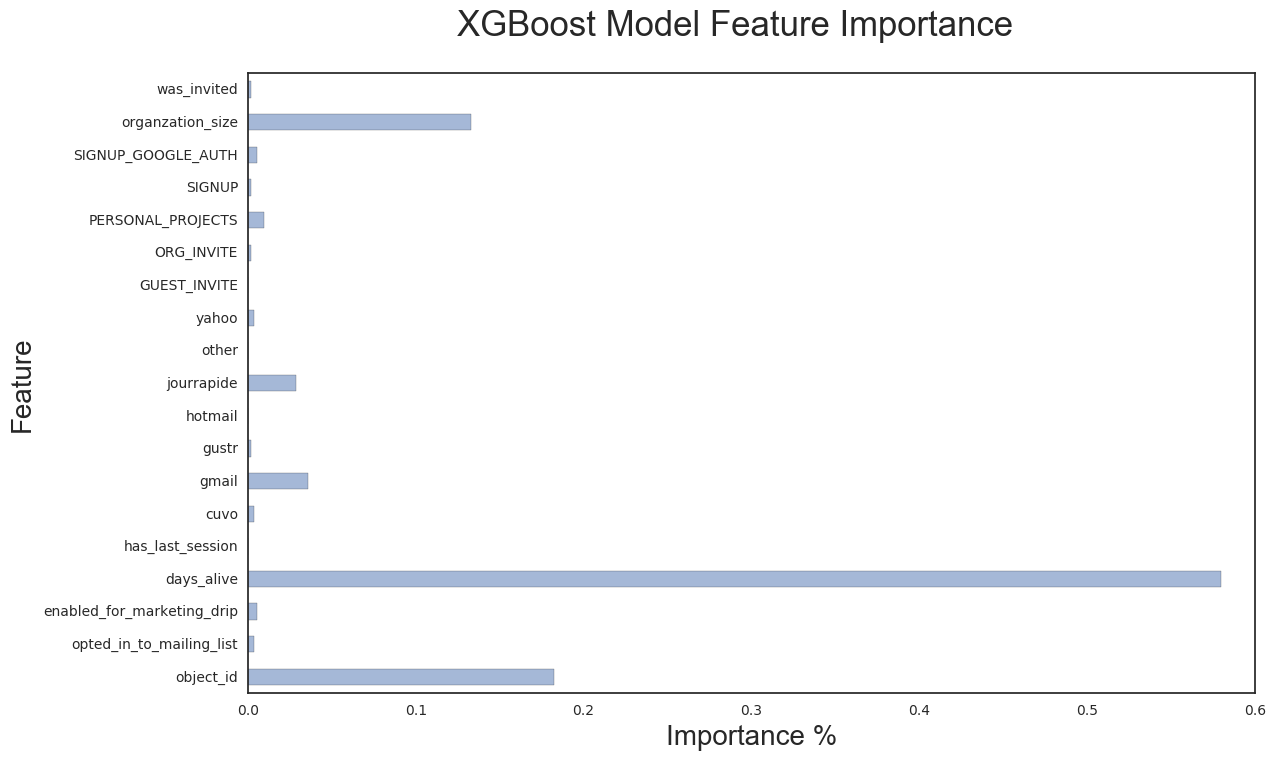

In [50]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
model = XGBClassifier()
model.fit(X, Y)

importance_series = pd.Series(model.feature_importances_, \
                              index=users_df_complete.columns[:-1])

fig = plt.figure(figsize=(13, 8))
fig.suptitle('XGBoost Model Feature Importance', fontsize=25)
plt.xlabel("Importance %", fontsize=20)
plt.ylabel("Feature", fontsize=20)
importance_series.plot(kind='barh', alpha = 0.5)

## Conclusions
After a lengthy data-cleaning process, we were able to quickly run some models and we were able to get some predictive power! As expected, the most important feature was days_alive, i.e. the difference between the last time the user logged into his/her account and the creation date. This is due to two reasons:

1. Adopted users (those who use the product) probably use Asana more often than users who who don't, which means they probably log in more frequently. 
2. A large days_alive metric also means that the user created his/her account a long time ago, which means that have had many opportunities to log in 3 times in a 7 day period. 

In addition to days_alive, there were 4 more features that were significant: object id, gmail, jourrapide, and organization size. 

1. object id: A smaller id means that the user was created before a user of a higher object id, which means those with higher ids are more likely to have Asana for a long time. 
2. gmail: our model says that users with gmail accounts are more likely to be adopted users than those without. 
3. jourrapide: our model says that those with jourrapide are less likely to be adopted users, probably because they are fake email accounts. 
4. organization size: our model says that users who belong to large organizations are more likely to be adopted users. I would guess this is the case because Asana has more customers/is more useful in larger companies. 

That's it! Hope you enjoyed reading my take-home challenge!